In [15]:
import pandas as pd
import torch
import json
import os
import argparse
import random
import pickle
import numpy as np
from collections import defaultdict
from operator import itemgetter
from scipy.stats import rankdata
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import gzip
from pprint import pprint
from scipy.stats import ttest_ind
#from sklearn.cluster.bicluster import SpectralCoclustering
from sklearn.cluster import KMeans
from sklearn import manifold


import data
import data_config

import warnings
warnings.filterwarnings("ignore")

In [2]:
sns.set(rc={'figure.figsize':(15,10)})
sns.set(font_scale=1.5)
sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})


In [2]:
def reverse_rankdata(a):
    return rankdata([-1 * i for i in a]).astype(int)

def generate_p_val(a, b):
    t, p = ttest_ind(a, b, equal_var=False)
    print("ttest_ind:            t = %g  p = %g" % (t, p))

In [16]:
dir_name = 'model_save'

PDTC

In [10]:
auc_ft_report, auc_ft_report_std, auc_ft_result_dict = generate_best_params(method = "code_adv_norm",pdtc_flag=True, folder=dir_name,metric_name='auroc', measurement='AUC')


wee code_adv_norm pretrain_num_epochs_100_train_num_epochs_1000_dop_0.0_ft_evaluation_results.json  :  0.7280000000000001 0.05306599664568641
5z code_adv_norm pretrain_num_epochs_0_train_num_epochs_2500_dop_0.0_ft_evaluation_results.json  :  0.5678571428571428 0.08777289805317502
ruc code_adv_norm pretrain_num_epochs_100_train_num_epochs_3000_dop_0.0_ft_evaluation_results.json  :  0.6857142857142857 0.03312006605534184
aic code_adv_norm pretrain_num_epochs_100_train_num_epochs_2500_dop_0.0_ft_evaluation_results.json  :  0.60625 0.17661088938680988
mot code_adv_norm pretrain_num_epochs_300_train_num_epochs_3000_dop_0.1_ft_evaluation_results.json  :  0.6199999999999999 0.0764198926981712
axi code_adv_norm pretrain_num_epochs_0_train_num_epochs_2500_dop_0.1_ft_evaluation_results.json  :  0.7160000000000001 0.020591260281974007
az628 code_adv_norm pretrain_num_epochs_0_train_num_epochs_500_dop_0.1_ft_evaluation_results.json  :  0.612 0.05418486873657627
azd6482 code_adv_norm pretrain_num_e

In [11]:
auc_ft_result_dict

defaultdict(dict,
            {'wee': {'pretrain_num_epochs_100_train_num_epochs_1000_dop_0.0_ft_evaluation_results.json': [0.64,
               0.7,
               0.78,
               0.78,
               0.7400000000000001]},
             '5z': {'pretrain_num_epochs_0_train_num_epochs_2500_dop_0.0_ft_evaluation_results.json': [0.7142857142857142,
               0.46428571428571425,
               0.5,
               0.6071428571428571,
               0.5535714285714286]},
             'ruc': {'pretrain_num_epochs_100_train_num_epochs_3000_dop_0.0_ft_evaluation_results.json': [0.7142857142857143,
               0.6607142857142857,
               0.6785714285714285,
               0.7321428571428572,
               0.6428571428571428]},
             'aic': {'pretrain_num_epochs_100_train_num_epochs_2500_dop_0.0_ft_evaluation_results.json': [0.28125,
               0.6875,
               0.5625,
               0.765625,
               0.734375]},
             'mot': {'pretrain_num_epoc

## Chemotherapy Drug Response Prediction

In [17]:
def get_largest_kv(d, std_dict):
    k = max(d.items(), key=itemgetter(1))[0]
    return k, d[k], std_dict[k]

def parse_param_str(param_str):
    pattern = re.compile('(pretrain_num_epochs)?_?(\d+)?_?(train_num_epochs)_(\d+)_(dop)_(\d\.\d)')
    matches = pattern.findall(param_str)
    return {matches[0][i]: float(matches[0][i+1]) for i in range(0,len(matches[0]), 2) if matches[0][i] != ''}

def parse_ft_evaluation_result(file_name, method, category, measurement='AUC',metric_name='auroc',pdtc_flag=False,folder = dir_name):
    if pdtc_flag:
        folder = f'{folder}/{method}/{measurement}/pdtc/{category}'
    else:
        folder = f'{folder}/{method}/{measurement}/{category}'        
    with open(os.path.join(folder, file_name), 'r') as f:
        result_dict = json.load(f)
    if 'enet' in result_dict:
        result_dict = result_dict['enet'][0]
    return result_dict[metric_name]

In [18]:
import re
from collections import Counter

def parse_hyper_ft_evaluation_result(method, category, measurement='AUC',metric_name='auroc', pdtc_flag = False, folder=dir_name):
    if pdtc_flag:
        folder = f'{folder}/{method}/{measurement}/pdtc/{category}'
    else:
        folder = f'{folder}/{method}/{measurement}/{category}'        
    evaluation_metrics = {}
    evaluation_metrics_std = {}
    evaluation_metrics_count = {}
    count = 0
    for file in os.listdir(folder):
        if re.match('(pretrain|train)+.*(dop+).*(ft)+.*\.json', file) or file == 'ft_evaluation_results.json':
            count += 1
            with open(os.path.join(folder, file), 'r') as f:
                result_dict = json.load(f)
            
            if 'enet' in result_dict:
                result_dict = result_dict['enet'][0]
            
            evaluation_metrics[file] = np.mean(result_dict[metric_name])
            evaluation_metrics_std[file] = np.std(result_dict[metric_name])
            evaluation_metrics_count[file] = len(Counter(result_dict[metric_name]))/len(result_dict[metric_name])
    to_exclude = []
    for k, v in evaluation_metrics_count.items():
        if v < 0.6: 
            to_exclude.append(k)
            
    if len(to_exclude)>0:
        for k in to_exclude:
            evaluation_metrics.pop(k)
            evaluation_metrics_std.pop(k)
                    
    return evaluation_metrics, evaluation_metrics_std, count
            

In [19]:
#新写一个函数，得到adv中最好的order
def generate_best_params(method = "code_adv_norm",metric_name='auroc', measurement='AUC', pdtc_flag=False, folder=dir_name):
    # methods = ['enet','rf','cell_enet','mlp','ae','dae_norm', 'vae','vaen','coxen','coxrf','coral_norm', 'adae_norm','velodrome', 'tcrp','dsna_norm','dsn_norm','code_adv_norm','deconvolution']
    if pdtc_flag:
        categories = pd.read_csv(data_config.gdsc_pdtc_drug_name_mapping_file, index_col=0).index.tolist()
    else:    
        categories = ['tgem', 'tfu','tem', 'gem', 'cis', 'sor', 'fu']

    report = pd.DataFrame(np.zeros((1, len(categories))),index=[method],columns=categories)
    report_std = pd.DataFrame(np.zeros((1, len(categories))), index=[method],columns=categories)
    result_dict = defaultdict(dict)

    for cat in categories:
        # print(f'{method}: {cat}')
        folder = f'{folder}/{method}'
        try:
            param_str, report.loc[method,cat], report_std.loc[method,cat] = get_largest_kv(d = parse_hyper_ft_evaluation_result(method=method, category=cat, metric_name=metric_name, measurement=measurement, pdtc_flag=pdtc_flag,folder=dir_name)[0],
                                                                                               std_dict = parse_hyper_ft_evaluation_result(method=method, category=cat, metric_name=metric_name, measurement=measurement, pdtc_flag=pdtc_flag,folder=dir_name)[1])
            # print(param_str) 
            
            print(cat,method,param_str," : ",report.loc[method, cat], report_std.loc[method, cat])
            if method in ['enet', 'rf', 'cell_enet']:
                result_dict[cat][param_str] = parse_ft_evaluation_result(file_name = 'ft_evaluation_results.json', method=method, category=cat, metric_name=metric_name, measurement=measurement, pdtc_flag=pdtc_flag,folder=dir_name)
            else:
                result_dict[cat][param_str] = parse_ft_evaluation_result(file_name = param_str, 
                                                                          method=method, category=cat, 
                                                                          metric_name=metric_name, 
                                                                          measurement=measurement, 
                                                                          pdtc_flag=pdtc_flag,
                                                                          folder=dir_name)

        except Exception as e:
                print(e)

                
    return report, report_std, result_dict


In [20]:
#新的
auc_ft_report, auc_ft_report_std, auc_ft_result_dict = generate_best_params(method = "code_adv_norm",pdtc_flag=False, folder=dir_name,metric_name='auroc', measurement='AUC')

tgem code_adv_norm pretrain_num_epochs_100_train_num_epochs_2500_dop_0.1_ft_evaluation_results.json  :  0.6333169533169534 0.0142672105342281
tfu code_adv_norm pretrain_num_epochs_300_train_num_epochs_2000_dop_0.0_ft_evaluation_results.json  :  0.7454857142857143 0.02264357367050153
tem code_adv_norm pretrain_num_epochs_100_train_num_epochs_500_dop_0.0_ft_evaluation_results.json  :  0.7240075614366729 0.014739953640542851
gem code_adv_norm pretrain_num_epochs_300_train_num_epochs_100_dop_0.1_ft_evaluation_results.json  :  0.5459357277882798 0.08574315779383225
cis code_adv_norm pretrain_num_epochs_100_train_num_epochs_500_dop_0.1_ft_evaluation_results.json  :  0.6459999999999999 0.028792360097775953
sor code_adv_norm pretrain_num_epochs_0_train_num_epochs_3000_dop_0.1_ft_evaluation_results.json  :  0.5159763313609468 0.016483299736312566
fu code_adv_norm pretrain_num_epochs_0_train_num_epochs_2500_dop_0.1_ft_evaluation_results.json  :  0.6290909090909091 0.06615783781330997


In [70]:
dir_name = 'model_save'
auc_ft_report, auc_ft_report_std, auc_ft_result_dict = generate_best_params(method = "code_adv_norm",pdtc_flag=False, folder=dir_name,metric_name='auroc', measurement='AUC')


tgem code_adv_norm pretrain_num_epochs_300_train_num_epochs_2500_dop_0.0_ft_evaluation_results.json  :  0.6034889434889437 0.04710283261959799
tfu code_adv_norm pretrain_num_epochs_0_train_num_epochs_1000_dop_0.0_ft_evaluation_results.json  :  0.6980571428571429 0.013443031728029829
tem code_adv_norm pretrain_num_epochs_100_train_num_epochs_100_dop_0.1_ft_evaluation_results.json  :  0.6548204158790171 0.015569951063874463
gem code_adv_norm pretrain_num_epochs_0_train_num_epochs_300_dop_0.0_ft_evaluation_results.json  :  0.5073724007561438 0.07895820027043698
cis code_adv_norm pretrain_num_epochs_300_train_num_epochs_200_dop_0.1_ft_evaluation_results.json  :  0.6265 0.0759045453184459
sor code_adv_norm pretrain_num_epochs_100_train_num_epochs_1500_dop_0.0_ft_evaluation_results.json  :  0.6781065088757396 0.046229644934022734
fu code_adv_norm pretrain_num_epochs_0_train_num_epochs_500_dop_0.1_ft_evaluation_results.json  :  0.6036363636363636 0.03382013679588774


In [71]:
auc_ft_result_dict


defaultdict(dict,
            {'tgem': {'pretrain_num_epochs_300_train_num_epochs_2500_dop_0.0_ft_evaluation_results.json': [0.5316953316953317,
               0.601965601965602,
               0.6565110565110566,
               0.6518427518427519,
               0.5754299754299755]},
             'tfu': {'pretrain_num_epochs_0_train_num_epochs_1000_dop_0.0_ft_evaluation_results.json': [0.7217142857142858,
               0.6885714285714286,
               0.6908571428571428,
               0.7040000000000001,
               0.6851428571428572]},
             'tem': {'pretrain_num_epochs_100_train_num_epochs_100_dop_0.1_ft_evaluation_results.json': [0.6805293005671077,
               0.6427221172022684,
               0.6351606805293006,
               0.6578449905482042,
               0.6578449905482042]},
             'gem': {'pretrain_num_epochs_0_train_num_epochs_300_dop_0.0_ft_evaluation_results.json': [0.45368620037807184,
               0.5293005671077504,
               0.55954

In [72]:
#文章publish的结果
dir_name = '../intermediate_results/plot_data/tcga/model_save'
auc_ft_report, auc_ft_report_std, auc_ft_result_dict = generate_best_params(method = "adsn_norm",pdtc_flag=False, folder=dir_name,metric_name='auroc', measurement='AUC')

tgem adsn_norm pretrain_num_epochs_100_train_num_epochs_2000_dop_0.0_ft_evaluation_results.json  :  0.685963144963145 0.03869228930152629
tfu adsn_norm pretrain_num_epochs_100_train_num_epochs_200_dop_0.1_ft_evaluation_results.json  :  0.7068 0.03718345034544044
tem adsn_norm pretrain_num_epochs_100_train_num_epochs_200_dop_0.0_ft_evaluation_results.json  :  0.7508941398865785 0.015094491325275725
gem adsn_norm pretrain_num_epochs_0_train_num_epochs_200_dop_0.1_ft_evaluation_results.json  :  0.594461247637051 0.013870651287594824
cis adsn_norm pretrain_num_epochs_0_train_num_epochs_2500_dop_0.1_ft_evaluation_results.json  :  0.6515000000000001 0.06341135544995079
sor adsn_norm pretrain_num_epochs_300_train_num_epochs_750_dop_0.1_ft_evaluation_results.json  :  0.6305147928994084 0.01656804733727807
fu adsn_norm pretrain_num_epochs_100_train_num_epochs_2000_dop_0.1_ft_evaluation_results.json  :  0.8675454545454546 0.026721706284907398


In [73]:
auc_ft_result_dict

defaultdict(dict,
            {'tgem': {'pretrain_num_epochs_100_train_num_epochs_2000_dop_0.0_ft_evaluation_results.json': [0.7397714987714988,
               0.6574619164619165,
               0.6301891891891892,
               0.7112702702702702,
               0.6911228501228501]},
             'tfu': {'pretrain_num_epochs_100_train_num_epochs_200_dop_0.1_ft_evaluation_results.json': [0.7294285714285714,
               0.7294285714285713,
               0.6334285714285715,
               0.7282857142857143,
               0.7134285714285714]},
             'tem': {'pretrain_num_epochs_100_train_num_epochs_200_dop_0.0_ft_evaluation_results.json': [0.7637485822306237,
               0.7561871455576559,
               0.7618582230623819,
               0.7505160680529301,
               0.7221606805293005]},
             'gem': {'pretrain_num_epochs_0_train_num_epochs_200_dop_0.1_ft_evaluation_results.json': [0.6141209829867675,
               0.591436672967864,
               0.58198

In [62]:
#用文章参数跑的结果
dir_name = 'test_best'
auc_ft_report, auc_ft_report_std, auc_ft_result_dict = generate_best_params(method = "TCGA_norm",pdtc_flag=False, folder=dir_name,metric_name='auroc', measurement='AUC')
auc_ft_result_dict

max() arg is an empty sequence
max() arg is an empty sequence
max() arg is an empty sequence
max() arg is an empty sequence
max() arg is an empty sequence
max() arg is an empty sequence
max() arg is an empty sequence


defaultdict(dict, {})

In [ ]:
#

In [6]:
def generate_hyper_ft_report(metric_name='auroc', measurement='AUC', pdtc_flag=False, folder=dir_name):
    methods = ['enet','rf','cell_enet','mlp','ae','dae_norm', 'vae','vaen','coxen','coxrf','coral_norm', 'adae_norm','velodrome', 'tcrp','dsna_norm','dsn_norm','code_adv_norm','deconvolution']
    if pdtc_flag:
        categories = pd.read_csv(data_config.gdsc_pdtc_drug_name_mapping_file, index_col=0).index.tolist()
    else:    
        categories = ['tgem', 'tfu','tem', 'gem', 'cis', 'sor', 'fu']

    #categories = ['female', 'male']
    
    report = pd.DataFrame(np.zeros((len(methods), len(categories))), index=methods, columns=categories)
    report_std = pd.DataFrame(np.zeros((len(methods), len(categories))), index=methods, columns=categories)
    result_dict = defaultdict(dict)

    for cat in categories:
        for method in methods:
            #print(f'{method}: {cat}')
            folder = f'{folder}/{method}'
            try:
                param_str, report.loc[method, cat], report_std.loc[method, cat] = get_largest_kv(d = parse_hyper_ft_evaluation_result(method=method, category=cat, metric_name=metric_name, measurement=measurement, pdtc_flag=pdtc_flag,folder=dir_name)[0],
                                                                                                std_dict = parse_hyper_ft_evaluation_result(method=method, category=cat, metric_name=metric_name, measurement=measurement, pdtc_flag=pdtc_flag,folder=dir_name)[1])
                if method == "code_adv_norm":
                    print(cat,method,param_str," : ",report.loc[method, cat], report_std.loc[method, cat])
                if method in ['enet', 'rf', 'cell_enet']:
                    result_dict[cat][method] = parse_ft_evaluation_result(file_name = 'ft_evaluation_results.json', method=method, category=cat, metric_name=metric_name, measurement=measurement, pdtc_flag=pdtc_flag,folder=dir_name)
                else:
                    result_dict[cat][method] = parse_ft_evaluation_result(file_name = param_str, 
                                                                          method=method, category=cat, 
                                                                          metric_name=metric_name, 
                                                                          measurement=measurement, 
                                                                          pdtc_flag=pdtc_flag,
                                                                          folder=dir_name)

            except Exception as e:
                print(e)

                
    return report, report_std, result_dict


In [15]:
method = ['enet','rf','cell_enet','mlp','ae','dae_norm', 'vae','vaen','coxen','coxrf','coral_norm', 'adae_norm','velodrome', 'tcrp','dsna_norm','dsn_norm','code_adv_norm','deconvolution'][16]
cat = ['tgem', 'tfu','tem', 'gem', 'cis', 'sor', 'fu'][1]
a = parse_hyper_ft_evaluation_result(method=method, category=cat, metric_name="auroc", measurement="AUC", pdtc_flag=False) #已经在一组参数内求完均值了，正常有预训练和训练的共3*10*2=60组
aa = get_largest_kv(d = a[0],
                std_dict = a[1]) #拿到均值最大的一组,另一个是方差
aa

('pretrain_num_epochs_0_train_num_epochs_1000_dop_0.0_ft_evaluation_results.json',
 0.6980571428571429,
 0.013443031728029829)

In [80]:
aa

('train_num_epochs_500_dop_0.1_ft_evaluation_results.json',
 0.6415,
 0.03215587038162707)

In [7]:
auc_ft_report, auc_ft_report_std, auc_ft_result_dict = generate_hyper_ft_report(metric_name='auroc', measurement='AUC')
#auc_ft_report, auc_ft_report_std前两个是统计文件，用来直接看排名
#auc_ft_result_dict第三个是选出的最好的一组（5个）原始统计值，用于绘图

max() arg is an empty sequence
[Errno 2] No such file or directory: 'model_save/cell_enet/AUC/tgem'
[Errno 2] No such file or directory: 'model_save/ae/AUC/tgem'
[Errno 2] No such file or directory: 'model_save/vae/AUC/tgem'
max() arg is an empty sequence
[Errno 2] No such file or directory: 'model_save/coxen/AUC/tgem'
[Errno 2] No such file or directory: 'model_save/coxrf/AUC/tgem'
max() arg is an empty sequence
[Errno 2] No such file or directory: 'model_save/velodrome/AUC/tgem'
tgem code_adv_norm pretrain_num_epochs_300_train_num_epochs_2500_dop_0.0_ft_evaluation_results.json  :  0.6034889434889437 0.04710283261959799
max() arg is an empty sequence
[Errno 2] No such file or directory: 'model_save/cell_enet/AUC/tfu'
[Errno 2] No such file or directory: 'model_save/ae/AUC/tfu'
[Errno 2] No such file or directory: 'model_save/vae/AUC/tfu'
max() arg is an empty sequence
[Errno 2] No such file or directory: 'model_save/coxen/AUC/tfu'
[Errno 2] No such file or directory: 'model_save/coxrf

In [8]:
auc_ft_result_dict

defaultdict(dict,
            {'tgem': {'rf': [0.4574938574938575,
               0.46707616707616706,
               0.5987714987714987,
               0.46240786240786247,
               0.5584766584766585],
              'mlp': [0.6019656019656019,
               0.5243243243243243,
               0.5872235872235873,
               0.5041769041769042,
               0.6093366093366094],
              'dae_norm': [0.5454545454545454,
               0.536117936117936,
               0.5582309582309583,
               0.5685503685503686,
               0.5832923832923832],
              'adae_norm': [0.5862407862407862,
               0.6108108108108108,
               0.6054054054054056,
               0.5714987714987715,
               0.628992628992629],
              'tcrp': [0.6103194103194103,
               0.5670761670761671,
               0.4963144963144963,
               0.543980343980344,
               0.6068796068796068],
              'dsna_norm': [0.5469287469287469,
 

In [8]:
#average rank when predict chemotherapy prediction on relapses after treatment
auc_ft_report[['tem','gem','cis','sor','fu']].apply(reverse_rankdata, axis=0).mean(axis=1)

enet             11.4
rf                6.8
cell_enet        13.6
mlp               5.4
ae               13.6
dae_norm          5.8
vae              13.6
vaen             13.6
coxen            13.6
coxrf            13.6
coral_norm       13.6
adae_norm         9.6
velodrome        13.6
tcrp              5.4
dsna_norm         4.4
dsn_norm          4.2
code_adv_norm     3.0
deconvolution     4.0
dtype: float64

In [27]:
#average rank when predict chemotherapy prediction on clinical diagnosis
auc_ft_report[['tgem','tfu']].apply(reverse_rankdata, axis=0).mean(axis=1)

enet             14.0
rf                9.0
cell_enet        14.0
mlp               5.5
ae               14.0
dae_norm          4.0
vae              14.0
vaen             14.0
coxen            14.0
coxrf            14.0
coral_norm       14.0
adae_norm         3.0
velodrome        14.0
tcrp              5.5
dsna_norm         6.0
dsn_norm          4.0
code_adv_norm     2.5
deconvolution     5.5
dtype: float64

In [9]:
#average rank when predict chemotherapy prediction overall
auc_ft_report.apply(reverse_rankdata, axis=0).mean(axis=1)


enet             12.142857
rf                7.428571
cell_enet        13.714286
mlp               5.571429
ae               13.714286
dae_norm          5.285714
vae              13.714286
vaen             13.714286
coxen            13.714286
coxrf            13.714286
coral_norm       13.714286
adae_norm         7.714286
velodrome        13.714286
tcrp              5.571429
dsna_norm         4.857143
dsn_norm          4.285714
code_adv_norm     2.857143
deconvolution     4.000000
dtype: float64

In [29]:
auc_ft_report.apply(reverse_rankdata, axis=0).std(axis=1)


enet             4.000000
rf               2.429972
cell_enet        0.534522
mlp              1.112697
ae               0.534522
dae_norm         2.516611
vae              0.534522
vaen             0.534522
coxen            0.534522
coxrf            0.534522
coral_norm       0.534522
adae_norm        5.520524
velodrome        0.534522
tcrp             3.132016
dsna_norm        2.429972
dsn_norm         2.267787
code_adv_norm    1.380131
deconvolution    2.870208
dtype: float64

In [11]:
drug_mapping = pd.read_csv('../data/tcga_gdsc_drug_mapping.csv', index_col=0)

drug_dict = drug_mapping['gdsc_name'].to_dict()
drug_dict['tgem'] = 'Gemcitabine (diagnosis)'
drug_dict['tfu'] = '5-Fluorouracil (diagnosis)'

result_df = None
for cat in ['tgem', 'tfu', 'fu','tem', 'cis', 'sor', 'gem']:
    temp_df = pd.DataFrame.from_dict(auc_ft_result_dict[cat])
    temp_df = temp_df.rename(columns={'tcrp': 'TCRP',"dae_norm": "dae",'cell_enet':'CELLIGNER','dsn_norm':"dsn-mmd", 'dsna_norm': 'dsn-dann', 'code_adv_norm': 'code-ae-adv'})
    temp_df = temp_df.rename(columns={k: k.upper() for k in temp_df.columns})

    temp_df = pd.melt(temp_df)
    temp_df['drug'] = drug_dict[cat]
    temp_df['metric'] = 'AUC'
    result_df = pd.concat((result_df, temp_df))
        
result_df = result_df.rename(columns={'variable': 'method', 'value': 'auroc'})
method_order = ['RF','ENET','MLP', 'AE','DAE','VAE','CORAL','DSN-MMD','DSN-DANN', 'TCRP','VAEN','COXEN','COXRF','CELLIGNER','ADAE',"VELODROME", 'CODE-AE-ADV',"DECONVOLUTION"]
result_df.method = result_df.method.astype('category')
result_df.method.cat.set_categories(method_order, inplace=True)
result_df.sort_values(by='method', inplace=True)

drug_order = ['5-Fluorouracil (diagnosis)', '5-Fluorouracil', 'Temozolomide', 'Sorafenib','Gemcitabine (diagnosis)','Gemcitabine', 'Cisplatin']
result_df.drug = result_df.drug.astype('category')
result_df.drug.cat.set_categories(drug_order, inplace=True)
result_df.sort_values(by='drug', inplace=True)



In [12]:
palette ={
    'ENET':'mediumpurple', 
    'RF':'rebeccapurple',
    'MLP':'purple', 
    'AE':'palegreen',
    'DAE':'limegreen',
    'VAE':'seagreen',
    'VAEN': 'darkgreen',
    'CORAL':'orange',
    'ADAE':'blue', 
    'COXEN':'lightgray',
    'COXRF':'darkgray',
    'CELLIGNER':'darkslategray',
    'DSN-MMD':'gold',
    'DSN-DANN':'yellow', 
    'TCRP':'black',
    "VELODROME":"pink",
    'CODE-AE-ADV':'red',
    "DECONVOLUTION":'grey'}

# marker_dict = {
#     'ENET':'s', 
#     'RF':'s',
#     'MLP':'s', 
#     'AE':'P',
#     'DAE':'P',
#     'VAE':'P',
#     'VAEN': 'P',
#     'CORAL':'H',
#     'ADAE':'H', 
#     'COXEN':'X',
#     'COXRF':'X',
#     'CELLIGNER':'X',
#     "VELODROME":"H",
#     'DSN-MMD':'D',
#     'DSN-DANN':'D', 
#     'TCRP':'s',
#     'CODE-AE-ADV':'o'
# }

<Figure size 1080x720 with 0 Axes>

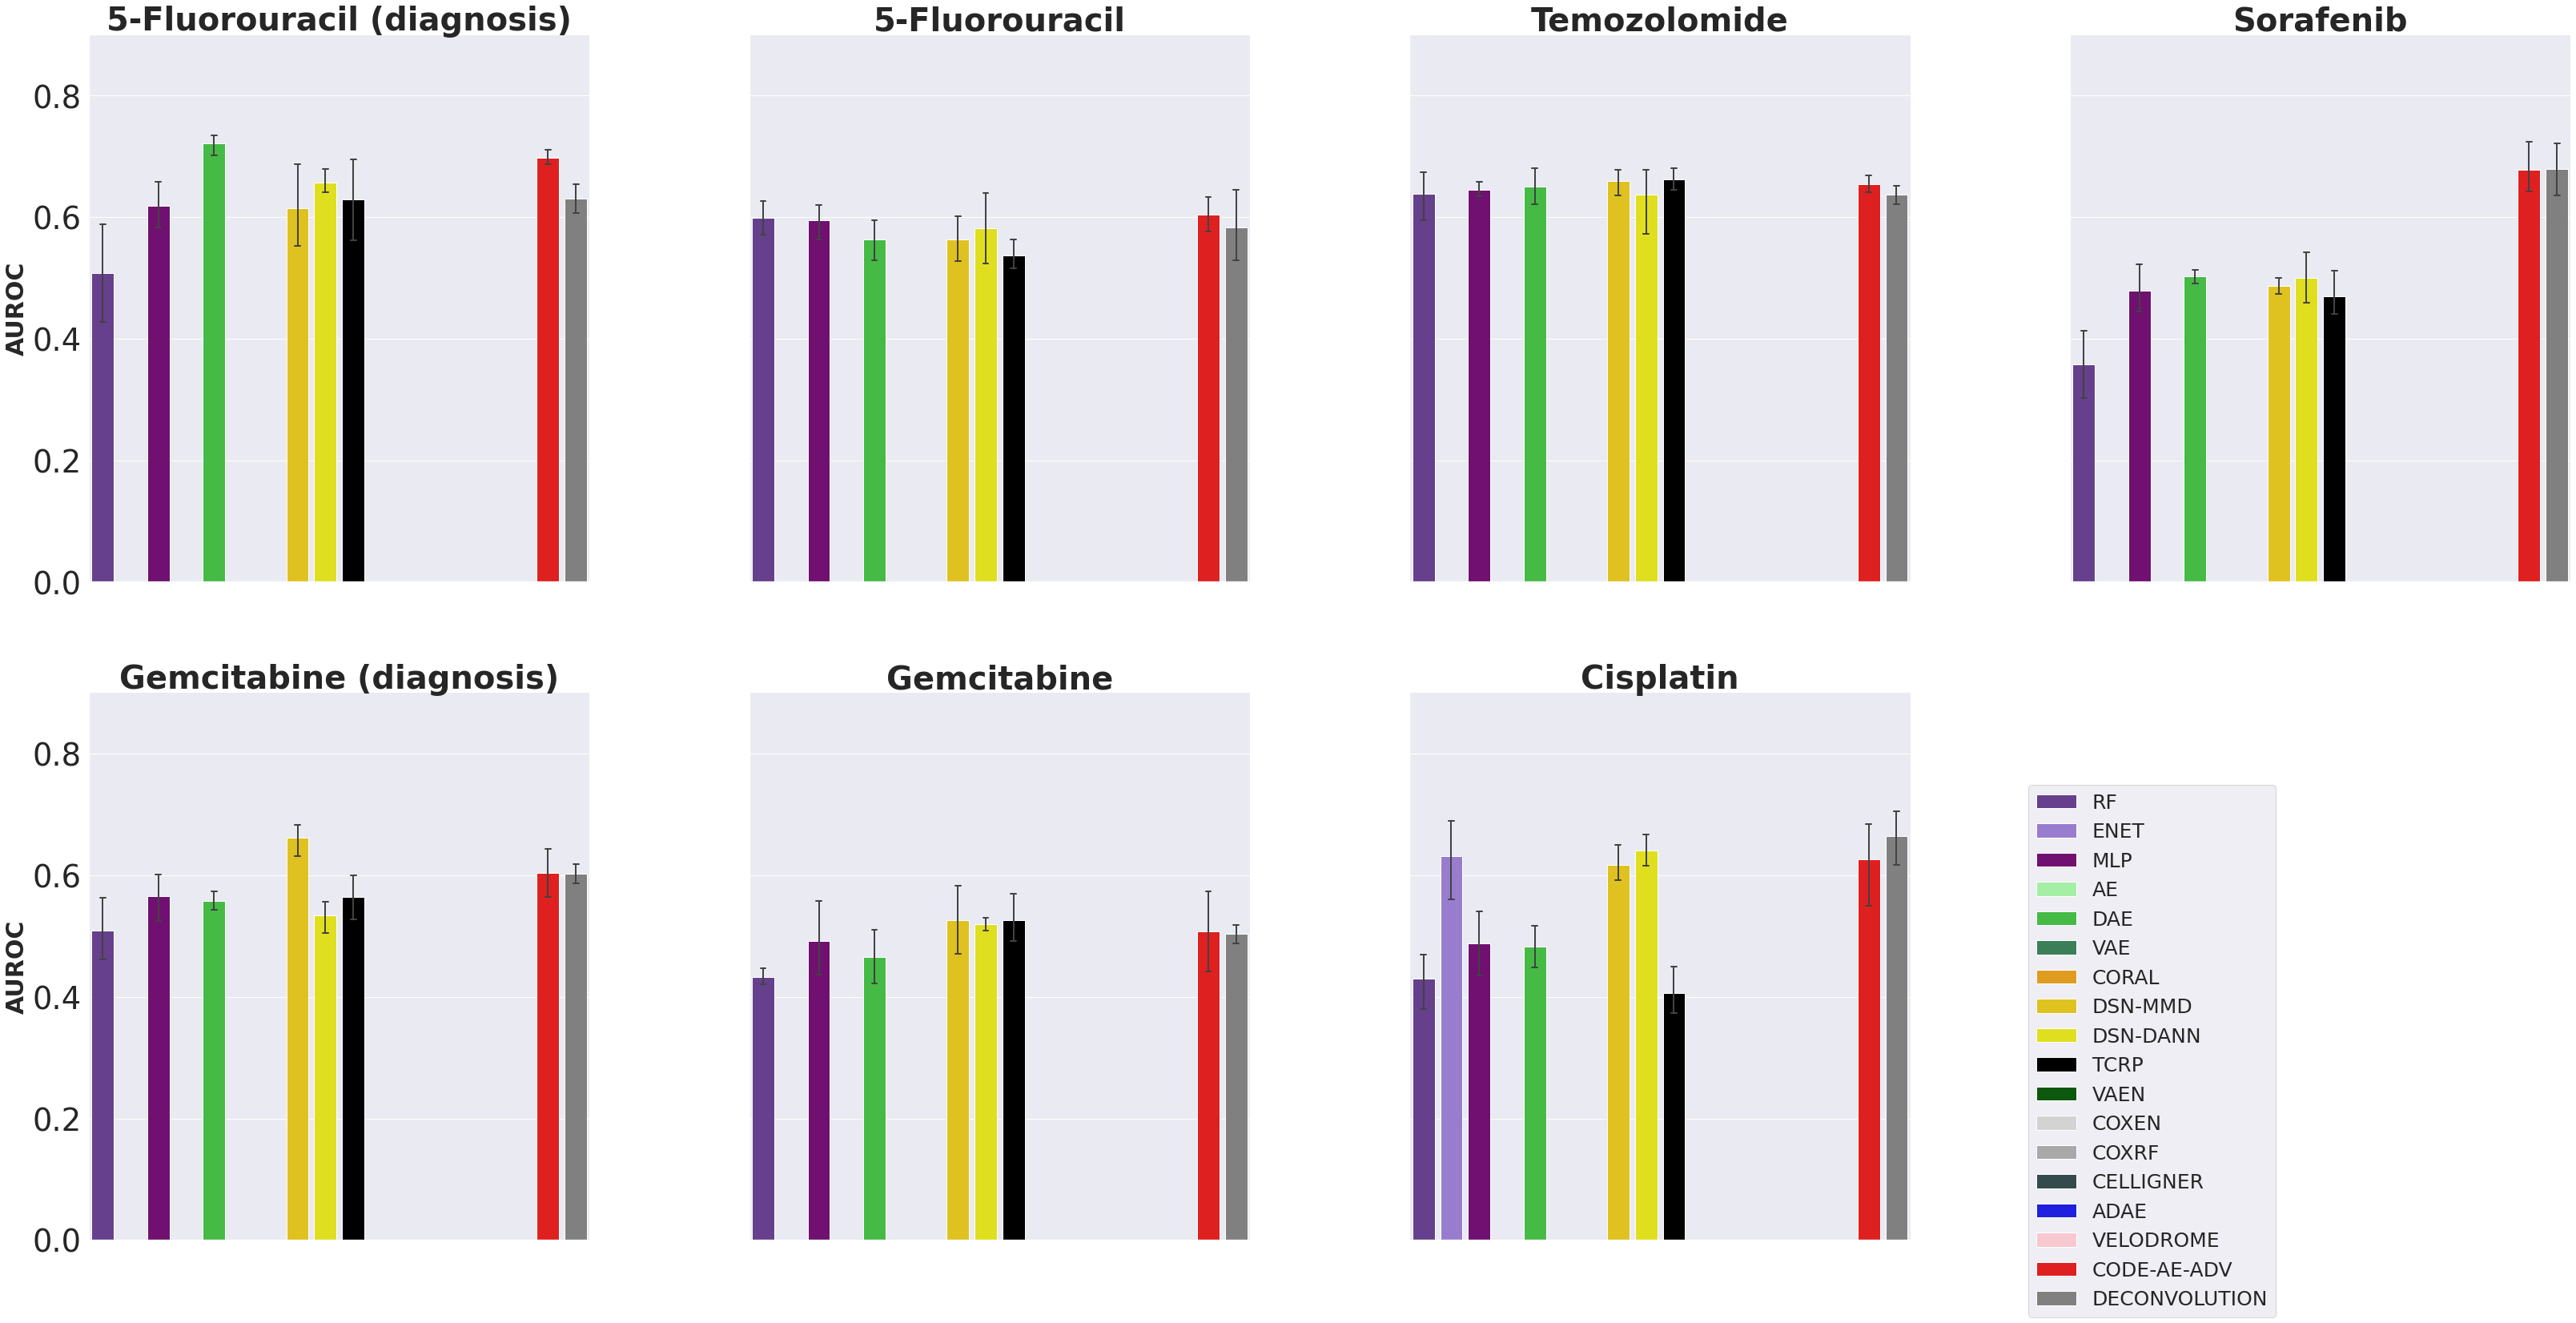

In [13]:
plt.figure(figsize=(15, 10))
sns.set(font_scale = 3.5)
g= sns.FacetGrid(result_df.loc[result_df.metric=='AUC'], col="drug", col_wrap=4, height=12)
g.map_dataframe(sns.barplot, x='method', y='auroc', hue='method', palette=palette, errwidth=2.0, capsize=0.2,dodge=False)
g.despine()
g.set_titles('{col_name}', size=40, weight='bold')
g.set(ylim=(0.0,0.9))
g.set_xlabels('')
g.set_ylabels('AUROC', size=30, weight='bold')
g.set_xticklabels("")
plt.legend(loc='upper right', bbox_to_anchor=(1.75, 0.85), fontsize=25)
#plt.savefig('../paper/tcga_auc_bar.png', format='png', dpi=350,bbox_inches='tight')

### AUPRC

In [31]:
auprc_ft_report, auprc_ft_report_std, auprc_ft_result_dict = generate_hyper_ft_report(metric_name='auprc', measurement='AUPRC')

max() arg is an empty sequence
max() arg is an empty sequence
max() arg is an empty sequence
max() arg is an empty sequence
max() arg is an empty sequence
max() arg is an empty sequence


In [32]:
#average rank when predict chemotherapy prediction on relapses after treatment
auprc_ft_report[['tem','gem','cis','sor','fu']].apply(reverse_rankdata, axis=0).mean(axis=1)

enet         13.8
rf           13.0
cell_enet    13.0
mlp          11.2
ae            9.4
dae           8.8
vae           7.6
vaen          6.4
coxen        10.8
coxrf        11.0
coral         6.6
adae          2.4
velodrome    10.8
tcrp         12.2
dsna          5.8
dsn           7.2
adsn_norm     1.6
dtype: float64

In [33]:
#average rank when predict chemotherapy prediction on clinical diagnosis
auprc_ft_report[['tgem','tfu']].apply(reverse_rankdata, axis=0).mean(axis=1)

enet         15.0
rf           14.5
cell_enet     9.5
mlp          11.0
ae            7.5
dae           6.0
vae           5.5
vaen          4.5
coxen        10.5
coxrf        16.5
coral        11.0
adae          2.5
velodrome    10.5
tcrp         12.0
dsna          7.5
dsn           5.5
adsn_norm     2.5
dtype: float64

In [34]:
#average rank when predict chemotherapy prediction overall
auprc_ft_report.apply(reverse_rankdata, axis=0).mean(axis=1)


enet         14.142857
rf           13.428571
cell_enet    12.000000
mlp          11.142857
ae            8.857143
dae           8.000000
vae           7.000000
vaen          5.857143
coxen        10.714286
coxrf        12.571429
coral         7.857143
adae          2.428571
velodrome    10.714286
tcrp         12.142857
dsna          6.285714
dsn           6.714286
adsn_norm     1.857143
dtype: float64

In [35]:
auprc_ft_report.apply(reverse_rankdata, axis=0).std(axis=1)


enet         4.259443
rf           2.070197
cell_enet    4.358899
mlp          2.544836
ae           3.023716
dae          3.265986
vae          3.785939
vaen         3.579040
coxen        5.964179
coxrf        3.735289
coral        3.023716
adae         1.272418
velodrome    5.964179
tcrp         2.544836
dsna         2.214670
dsn          3.988077
adsn_norm    1.214986
dtype: float64

In [36]:
result_df = None
for cat in ['tgem', 'tfu', 'fu','tem', 'cis', 'sor', 'gem']:
    temp_df = pd.DataFrame.from_dict(auprc_ft_result_dict[cat])
    temp_df = temp_df.rename(columns={'tcrp': 'TCRP','cell_enet':'CELLIGNER','dsn':"dsn-mmd", 'dsna': 'dsn-dann', 'code_adv_norm': 'code-ae-adv'})
    temp_df = temp_df.rename(columns={k: k.upper() for k in temp_df.columns})

    temp_df = pd.melt(temp_df)
    temp_df['drug'] = drug_dict[cat]
    temp_df['metric'] = 'AUPRC'
    result_df = pd.concat((result_df, temp_df))
        
result_df = result_df.rename(columns={'variable': 'method', 'value': 'auprc'})
method_order = ['RF','ENET','MLP', 'AE','DAE','VAE','CORAL','DSN-MMD','DSN-DANN', 'TCRP','VAEN','COXEN','COXRF','CELLIGNER','ADAE',"VELODROME", 'CODE-AE-ADV']
result_df.method = result_df.method.astype('category')
result_df.method.cat.set_categories(method_order, inplace=True)
result_df.sort_values(by='method', inplace=True)

drug_order = ['5-Fluorouracil (diagnosis)', '5-Fluorouracil', 'Temozolomide', 'Sorafenib','Gemcitabine (diagnosis)','Gemcitabine', 'Cisplatin']
result_df.drug = result_df.drug.astype('category')
result_df.drug.cat.set_categories(drug_order, inplace=True)
result_df.sort_values(by='drug', inplace=True)

<Figure size 1080x720 with 0 Axes>

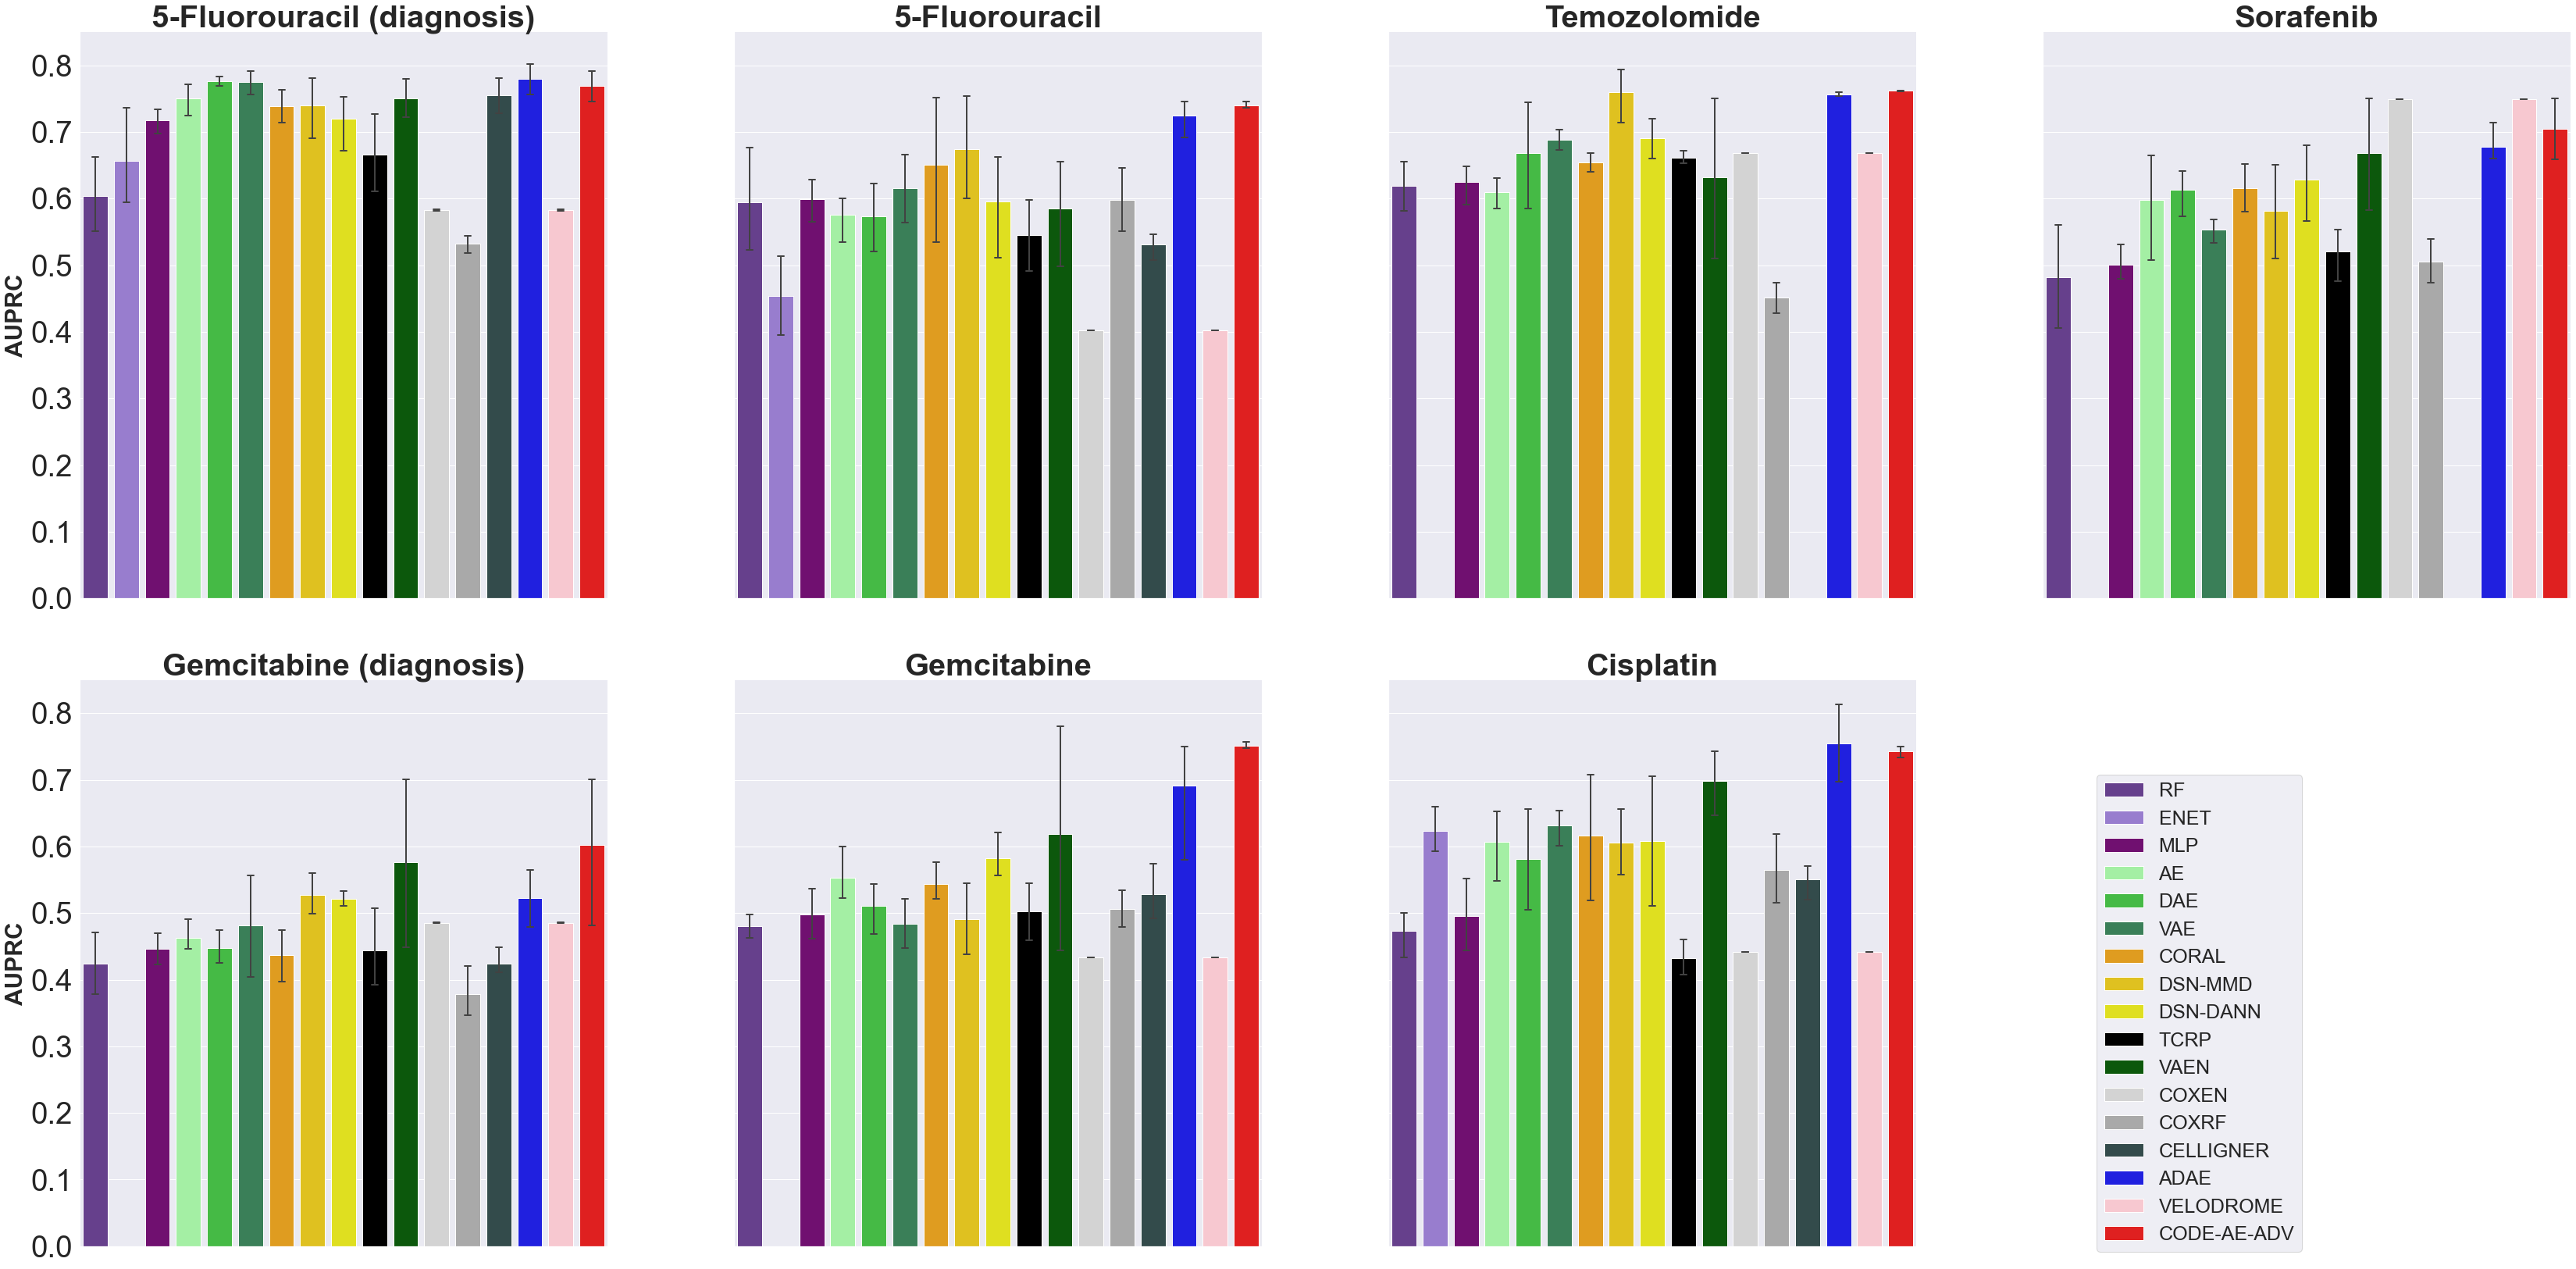

In [37]:
plt.figure(figsize=(15, 10))
sns.set(font_scale = 3.5)
g= sns.FacetGrid(result_df.loc[result_df.metric=='AUPRC'], col="drug", col_wrap=4, height=12)
g.map_dataframe(sns.barplot, x='method', y='auprc', hue='method', palette=palette, errwidth=2.0, capsize=0.2,dodge=False)
g.despine()
g.set_titles('{col_name}', size=40, weight='bold')
g.set(ylim=(0.0,0.85))
g.set_xlabels('')
g.set_ylabels('AUPRC', size=30, weight='bold')
g.set_xticklabels("")
plt.legend(loc='upper right', bbox_to_anchor=(1.75, 0.85), fontsize=25)
#plt.savefig('../paper/tcga_auprc_bar.png', format='png', dpi=350,bbox_inches='tight')

In [39]:
## check p vals
print('Gemcitabine (diagnosis): rank 1')
generate_p_val(a=auc_ft_result_dict['tgem']['code_adv_norm'], b=auc_ft_result_dict['tgem']['vaen'])
print('5-Fluorouracil (diagnosis): rank 2')
generate_p_val(a=auc_ft_result_dict['tfu']['code_adv_norm'], b=auc_ft_result_dict['tfu']['adae'])
print('5-Fluorouracil: rank 1')
generate_p_val(a=auc_ft_result_dict['fu']['code_adv_norm'], b=auc_ft_result_dict['fu']['adae'])
print('Temozolomide: rank 1')
generate_p_val(a=auc_ft_result_dict['tem']['code_adv_norm'], b=auc_ft_result_dict['tem']['adae'])
print('Sorafenib: rank 3')
generate_p_val(a=auc_ft_result_dict['sor']['code_adv_norm'], b=auc_ft_result_dict['sor']['velodrome'])
print('Gemcitabine: rank 1')
generate_p_val(a=auc_ft_result_dict['gem']['code_adv_norm'], b=auc_ft_result_dict['gem']['adae'])
print('Cisplatin: rank 2')
generate_p_val(a=auc_ft_result_dict['cis']['code_adv_norm'], b=auc_ft_result_dict['cis']['adae'])

Gemcitabine (diagnosis): rank 1
ttest_ind:            t = 8.57459  p = 0.000379119
5-Fluorouracil (diagnosis): rank 2
ttest_ind:            t = 0.699231  p = 0.518632
5-Fluorouracil: rank 1
ttest_ind:            t = 8.42216  p = 4.69713e-05
Temozolomide: rank 1
ttest_ind:            t = 4.94461  p = 0.0020183
Sorafenib: rank 3
ttest_ind:            t = 8.09469  p = 0.000101699
Gemcitabine: rank 1
ttest_ind:            t = 2.27469  p = 0.0817732
Cisplatin: rank 2
ttest_ind:            t = 0.237033  p = 0.82131


### tSNE plots for difference features

In [192]:
tsne = manifold.TSNE(n_components=2, init='random',random_state=0)


In [201]:
ori_gex = pd.read_csv('../data/preprocessed_dat/uq1000_feature.csv', index_col=0)
gex_label = ['TCGA'] * 9808 + ['CCLE']*1305


In [202]:
ori_gex_y = tsne.fit_transform(ori_gex)

In [205]:
ori_encoder_feature_df = pd.DataFrame(ori_gex_y, columns=['x','y'])
ori_encoder_feature_df['Sample'] = gex_label

Text(0.5, 1.0, 'Original')

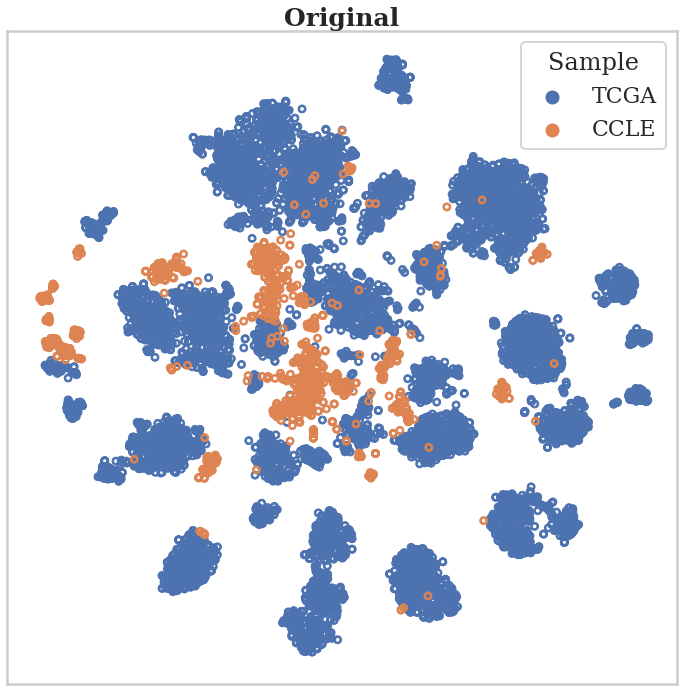

In [208]:
plt.figure(figsize=(12,12))
sns.set(font_scale = 2.0)
sns.set_context('poster')
sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})


ax = sns.scatterplot(x='x',y='y',data=ori_encoder_feature_df,hue='Sample', marker="$\circ$", ec="face")
plt.xlabel('')
plt.ylabel("")
plt.yticks([],fontsize=15, weight='bold')
plt.xticks([],fontsize=15, weight='bold')
plt.title('Original', fontsize=25, weight='bold')
#plt.savefig(f'../intermediate_results/encoded_features/Original_tSNE.png', format='png', dpi=350,bbox_inches='tight')


In [209]:
ccle_gex = pd.read_csv(f'../intermediate_results/encoded_features/ae_ccle_features.csv',index_col=0)
tcga_gex = pd.read_csv(f'../intermediate_results/encoded_features/ae_tcga_features.csv',index_col=0)
ae_all_gex = pd.concat([tcga_gex, ccle_gex])
ae_all_gex_y = tsne.fit_transform(ae_all_gex)


    

Text(0.5, 1.0, 'AE')

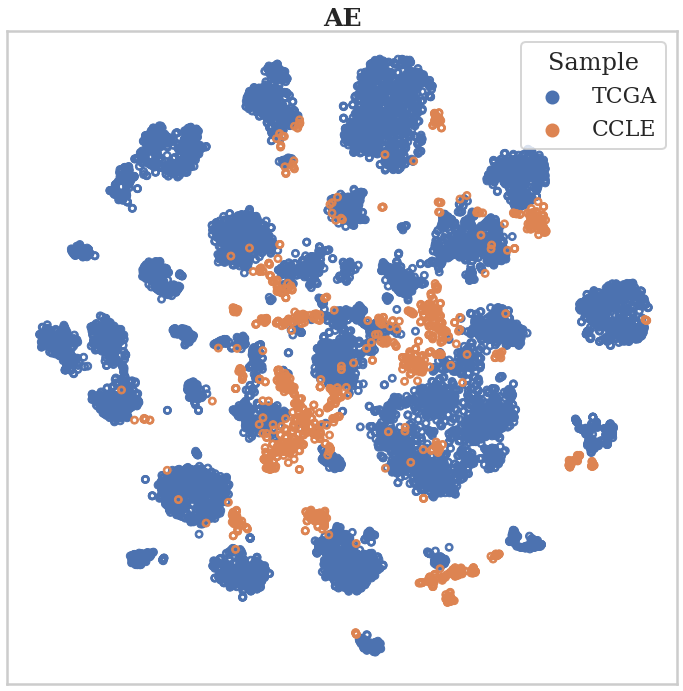

In [211]:
ae_encoder_feature_df = pd.DataFrame(ae_all_gex_y, columns=['x','y'])
ae_encoder_feature_df['Sample'] = gex_label

plt.figure(figsize=(12,12))
sns.set_context('poster')
sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})

ax = sns.scatterplot(x='x',y='y',data=ae_encoder_feature_df,hue='Sample', marker="$\circ$", ec="face")
plt.xlabel('')
plt.ylabel("")
plt.yticks([],fontsize=15, weight='bold')
plt.xticks([],fontsize=15, weight='bold')
plt.title('AE', fontsize=25, weight='bold')
#plt.savefig(f'../intermediate_results/encoded_features/AE_tSNE.png', format='png', dpi=350,bbox_inches='tight')


In [212]:
ccle_gex = pd.read_csv(f'../intermediate_results/encoded_features/codeae_ccle_features.csv',index_col=0)
tcga_gex = pd.read_csv(f'../intermediate_results/encoded_features/codeae_tcga_features.csv',index_col=0)
codeae_all_gex = pd.concat([tcga_gex, ccle_gex])
codeae_all_gex_y = tsne.fit_transform(codeae_all_gex)


    

Text(0.5, 1.0, 'AE')

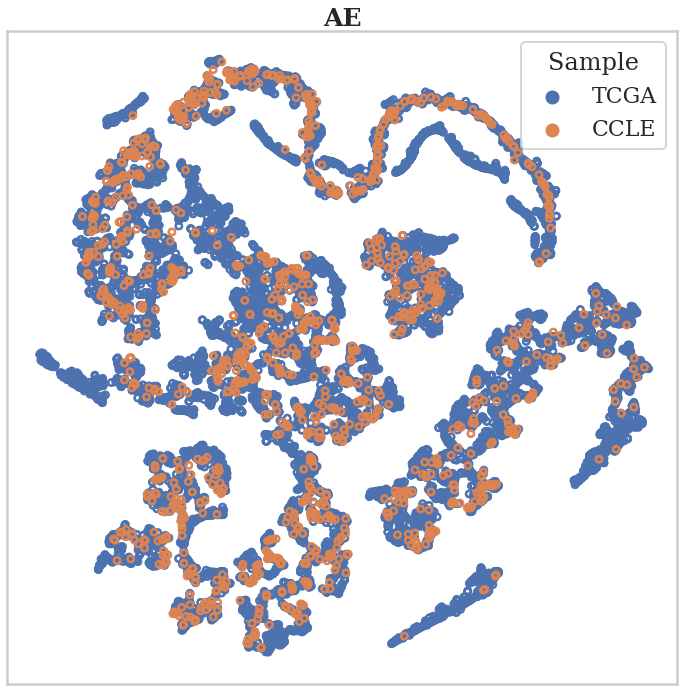

In [213]:
codeae_encoder_feature_df = pd.DataFrame(codeae_all_gex_y, columns=['x','y'])
codeae_encoder_feature_df['Sample'] = gex_label

plt.figure(figsize=(12,12))
sns.set_context('poster')
sns.set_style('whitegrid', {'font.family':'serif', 'font.serif':'Times New Roman'})

ax = sns.scatterplot(x='x',y='y',data=codeae_encoder_feature_df,hue='Sample', marker="$\circ$", ec="face")
plt.xlabel('')
plt.ylabel("")
plt.yticks([],fontsize=15, weight='bold')
plt.xticks([],fontsize=15, weight='bold')
plt.title('AE', fontsize=25, weight='bold')
#plt.savefig(f'../intermediate_results/encoded_features/CODEAE_tSNE.png', format='png', dpi=350,bbox_inches='tight')
